In [1]:
import fastai
import os

print(fastai.__version__)
print(os.getenv("PYTORCH_ENABLE_MPS_FALLBACK"))

# https://github.com/microsoft/vscode-jupyter/issues/13163
from IPython.display import clear_output, DisplayHandle


def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)


DisplayHandle.update = update_patch

2.7.12
1


In [2]:
from fastai.vision.all import *
from pathlib import Path
import pandas as pd

In [3]:
df = pd.read_csv("labels.csv")
df.tail(5)

,filename,label
795,British_Shorthair_21.jpg,cat
796,Siamese_149.jpg,cat
797,Siamese_89.jpg,cat
798,Birman_156.jpg,cat
799,Abyssinian_228.jpg,cat


In [4]:
# df = df.sample(frac=0.1)

In [5]:
def get_x(x):
    return Path("data") / x["filename"]


def get_y(x):
    return x["label"]

In [6]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=TrainTestSplitter(test_size=0.2, random_state=42, stratify=df["label"]),
    item_tfms=[RandomResizedCrop(224 + 40, min_scale=0.35)],
    batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)],
)


Setting-up type transforms pipelines
0    img-a0597963-343c-4a36-989b-0cc0e409d84a  nocat
1    img-16ee8d52-2177-495a-87e8-f7fa6c151954  nocat
2    img-b522ffe9-9782-43f7-9161-edbccda5dd42  nocat
3    img-7e613dd5-fb25-4669-bc34-fbbc32ad0542  nocat
4    img-4bded52e-129f-4794-ad70-1e003a363110  nocat
..                                        ...    ...
795                  British_Shorthair_21.jpg    cat
796                           Siamese_149.jpg    cat
797                            Siamese_89.jpg    cat
798                            Birman_156.jpg    cat
799                        Abyssinian_228.jpg    cat

[800 rows x 2 columns]
Found 800 items
2 datasets of sizes 640,160
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      filename    Ragdoll_168.jpg
label                   cat
Name: 721, dtype: object
    applying g

/Users/r/projects/ws-live/.venv/lib/python3.11/site-packages/torch/_tensor.py:1295: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  ret = func(*args, **kwargs)



Building one batch
Applying item_tfms to the first sample:
  Pipeline: RandomResizedCrop -- {'size': (264, 264), 'min_scale': 0.35, 'ratio': (0.75, 1.3333333333333333), 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0} -> ToTensor
    starting from
      (PILImage mode=RGB size=422x500, TensorCategory(0))
    applying RandomResizedCrop -- {'size': (264, 264), 'min_scale': 0.35, 'ratio': (0.75, 1.3333333333333333), 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0} gives
      (PILImage mode=RGB size=264x264, TensorCategory(0))
    applying ToTensor gives
      (TensorImage of size 3x264x264, TensorCategory(0))

Adding the next 1 samples

No before_batch transform to apply

Collating items in a batch

Applying batch_tfms to the batch built
  Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflect

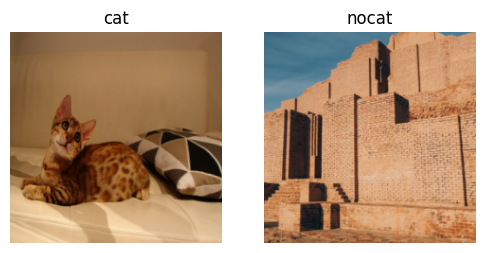

In [7]:
dblock.summary(df, show_batch=True, bs=2)

In [8]:
dls = dblock.dataloaders(df, bs=32)

In [9]:
learn = vision_learner(dls, resnet18, metrics=accuracy)

/Users/r/projects/ws-live/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/r/projects/ws-live/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.043696,0.013802,0.993750,00:13


In [11]:
learn.export("test.pkl")